

<H1 style="text-align: center">ECMM426 - Computer Vision </H1>
<H1 style="text-align: center"></H1>
<H1 style="text-align: center">Workshop 2</H1>
<H1 style="text-align: center">Corner Detection</H1>


In this workshop, we will implement a corner detection algorithm, specifically the Harris Corner Detection algorithm from scratch. Corner detection is an approach used within computer vision systems to extract certain kinds of features and infer the contents of an image. Corner detection is frequently used in motion detection, image registration, video tracking, image mosaicing, panorama stitching, 3D reconstruction, object recognition etc.


## Imports

In [1]:
import urllib
import matplotlib, cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['figure.dpi'] = 72
print('OpenCV version: {}'.format(cv2.__version__))

OpenCV version: 4.7.0


## Read and show the image

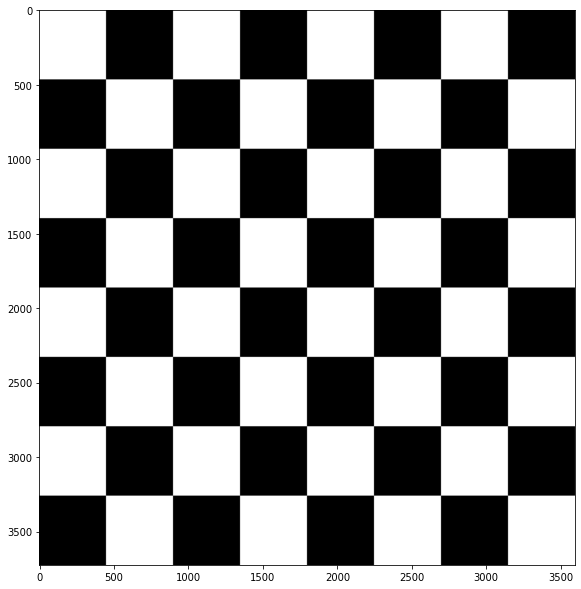

In [2]:
# read an image
img = cv2.imread('chessboard.png')

# convert image to grayscale
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)

# show the image
plt.imshow(gray_img, cmap='gray')

## Add border to detect all the corners

In order to make sure that our implemented algorithm can detect all the existing corners in the chessboard image, we add a black border around the image. This is to ensure that the computated gradient have comfortable size for the kernel we used. The `cv2.copyMakeBorder()` could be used to add the border around the image.

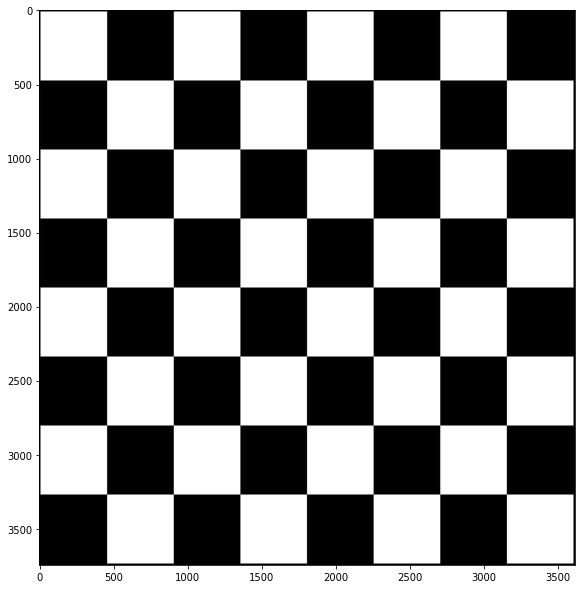

In [3]:
gray_img = cv2.copyMakeBorder(gray_img.copy(), 10, 10, 10, 10, cv2.BORDER_CONSTANT, value=[0, 0, 0])
# show the image
plt.imshow(gray_img, cmap='gray')

## Harris corner detection
We know that corners are regions in the image with large variation in intensity in all the directions. One early attempt to find these corners was done by **Chris Harris & Mike Stephens** in their paper **A Combined Corner and Edge Detector** in 1988, so now it is called the **Harris Corner Detector**. He took this simple idea to a mathematical form. It basically finds the difference in intensity for a displacement of (u,v) in all directions. This is expressed as below:

$$E(u,v) = \sum_{x,y} \underbrace{w(x,y)}_\text{window function} \, [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$$

The window function is either a rectangular window or a Gaussian window which gives weights to pixels underneath. For sake of simplicity we can consider:

$$E(u,v) = \sum_{x,y} [\underbrace{I(x+u,y+v)}_\text{shifted intensity}-\underbrace{I(x,y)}_\text{intensity}]^2$$

We have to maximize this function $E(u,v)$ for corner detection. 

Taylor's series expansion

$$f(x)=f(a+x-a)=\sum_{n=0}^{\infty} \frac{f^{(n)}(a)}{n!}(x-a)^n=f(a)+\frac{f^{(1)}(a)}{1!}(x-a)+\frac{f^{(2)}(a)}{2!}(x-a)^2+\ldots$$

Applying Taylor's expansion to the above equation

$$\begin{align}
I(x+u,y+v)&=I(x,y)+\frac{\partial I}{\partial x}u+\frac{\partial I}{\partial y}v+\frac{\partial^2 I}{\partial x^2}u^2+\frac{\partial^2 I}{\partial y^2}v^2+\ldots\\
&=I(x,y)+I_xu+I_yv+I_{xx}u^2+I_{yy}v^2+\ldots
\end{align}$$

Therefore,

$$E(u,v) \approx \sum_{x,y}(I_xu+I_yv)^2 \approx \sum_{x,y}I_xI_xu^2+2\sum_{x,y}I_xI_yuv+\sum_{x,y}I_yI_yv^2$$

 and using some mathematical steps (please refer to any standard text books you like for full derivation), we get the final equation as:

$$E(u,v) \approx \begin{bmatrix} u & v \end{bmatrix} M \begin{bmatrix} u \\ v \end{bmatrix}$$

where

$$M = \sum_{x,y} \begin{bmatrix}I_x I_x & I_x I_y \\ I_x I_y & I_y I_y \end{bmatrix}$$

Here, $I_x$ and $I_y$ are image derivatives in x and y directions respectively.

## Image gradient

First to compute the gradient along the X and Y directions, we create the Sobel kernels and use the `cv2.filter2D()` function for computing their response on the image. Here, we have to remember regarding the datatype for correctly processing the gradient images.

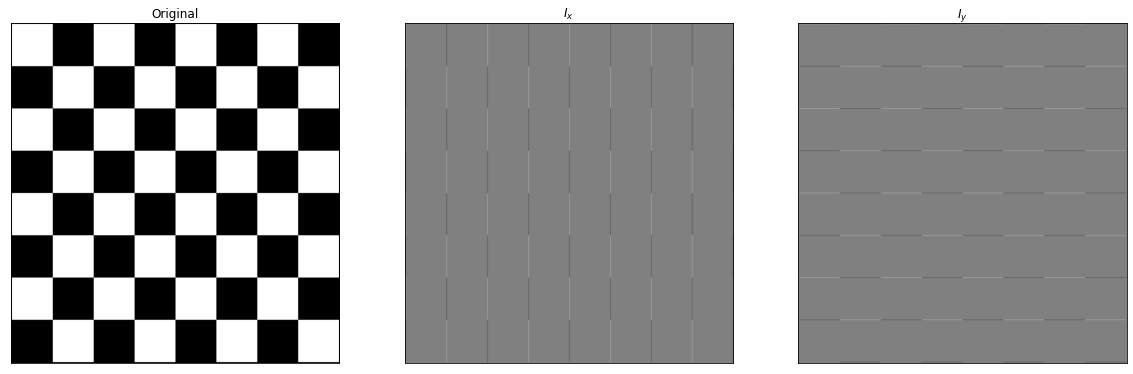

In [5]:
# construct the Sobel x-axis kernel
sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float64)
# construct the Sobel y-axis kernel
sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype=np.float64)
# convolution
I_x = cv2.filter2D(gray_img, -1, sobelX)
I_y = cv2.filter2D(gray_img, -1, sobelY)
# plot
plt.subplot(1,3,1),plt.imshow(gray_img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(I_x, cmap = 'gray')
plt.title('$I_x$'), plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(I_y, cmap = 'gray')
plt.title('$I_y$'), plt.xticks([]), plt.yticks([])
plt.show()

## Gradient covariances

Here, we compute the gradient covariences and apply smoothing to eliminate strong responses.

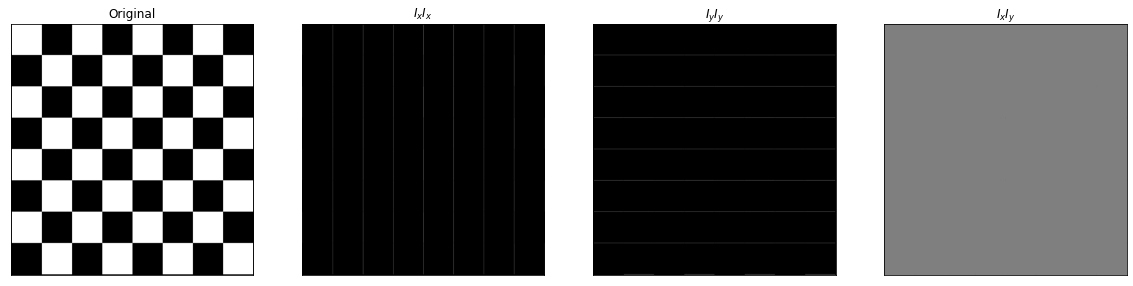

In [6]:
# Gradient covariance and light smoothing
I_x_I_x = cv2.GaussianBlur(I_x*I_x, (3, 3), sigmaX=1, sigmaY=1)
I_y_I_y = cv2.GaussianBlur(I_y*I_y, (3, 3), sigmaX=1, sigmaY=1)
I_x_I_y = cv2.GaussianBlur(I_x*I_y, (3, 3), sigmaX=1, sigmaY=1)

# plot
plt.subplot(1,4,1),plt.imshow(gray_img, cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,2),plt.imshow(I_x_I_x, cmap = 'gray')
plt.title('$I_xI_x$'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,3),plt.imshow(I_y_I_y, cmap = 'gray')
plt.title('$I_yI_y$'), plt.xticks([]), plt.yticks([])
plt.subplot(1,4,4),plt.imshow(I_x_I_y, cmap = 'gray')
plt.title('$I_xI_y$'), plt.xticks([]), plt.yticks([])
plt.show()

## Harris response calculation

Then comes the main part. After this, they created a score, basically an equation, which determines if a window can contain a corner or not.

$$R = \text{det}(M) - k(\text{trace}(M))^2$$

where
* $\text{det}(M) = \lambda_1 \lambda_2$
* $\text{trace}(M) = \lambda_1 + \lambda_2$
* $\lambda_1$ and $\lambda_2$ are the eigenvalues of $M$

In [7]:
k = 0.05
# determinant
detA = I_x_I_x * I_y_I_y - I_x_I_y ** 2
# trace
traceA = I_x_I_x + I_y_I_y
R = detA - k * traceA ** 2
print(f'max of R is {R.max()}')

max of R is 105904177152.0


## Find corners using R > 0

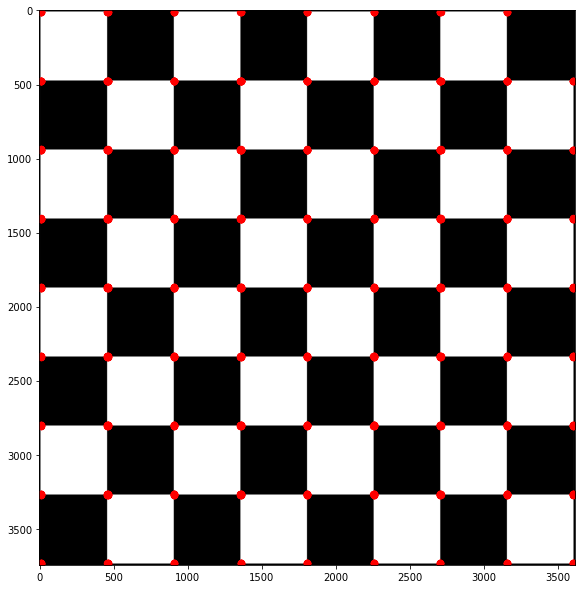

In [8]:
y, x = np.where(R > 0)
plt.figure()
plt.imshow(gray_img, cmap='gray')
plt.scatter(x, y, c='r', s=40)
plt.show()

## Find edges using R < 0

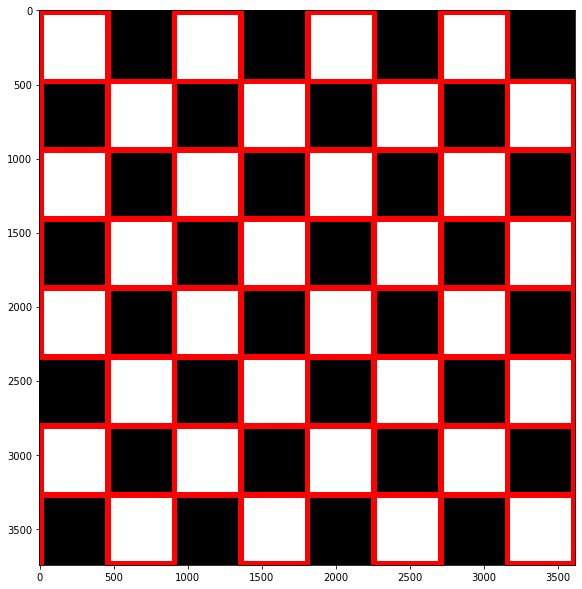

In [9]:
y, x = np.where(R < 0)
plt.figure()
plt.imshow(gray_img, cmap='gray')
plt.scatter(x, y, c='r', s=10)
plt.show()

## Find flat regions using R = 0

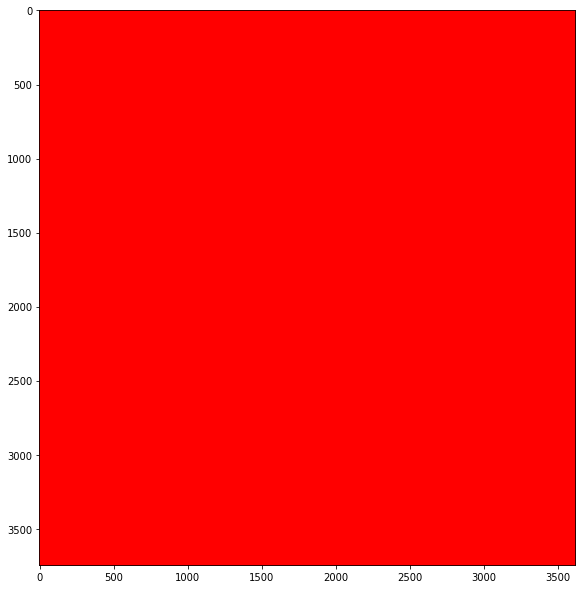

In [10]:
y, x = np.where(R == 0)
plt.figure()
plt.imshow(gray_img, cmap='gray')
plt.scatter(x, y, c='r', s=1)
plt.show()

## Non-maximum suppression

This is to compute the local maxima, which is readily achievable via the `corner_peaks()` function. Please have a look on the documentation [here](https://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.corner_peaks) for more details on its parameters.

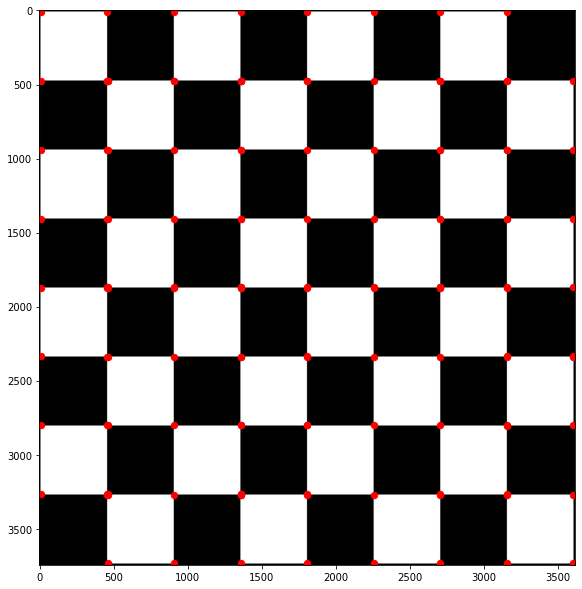

In [10]:
from skimage.feature import corner_peaks
# non-maximal suppression
corners = corner_peaks(R, threshold_abs=1000000)
x, y = corners[:, 1], corners[:, 0]
plt.figure()
plt.imshow(gray_img, cmap='gray')
plt.scatter(x, y, c='r', s=40)
plt.show()

## `HarrisCorner` function

Putting all the above required codes in a single function

In [14]:
from skimage.feature import corner_peaks
def HarrisCorner(img, ksize=5, sigmaX=2, sigmaY=2, k=0.05, non_max_suppr=True):
  # convert image to grayscale
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
  # light Gaussian smoothing
  gray_img = cv2.GaussianBlur(gray_img, (ksize, ksize), sigmaX=sigmaX, sigmaY=sigmaY)
  # construct the Sobel x-axis kernel
  sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float)
  # construct the Sobel y-axis kernel
  sobelY = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]), dtype=np.float)
  # convolution
  I_x = cv2.filter2D(gray_img, -1, sobelX)
  I_y = cv2.filter2D(gray_img, -1, sobelY)
  # gradient covariances and light Gaussian smoothing
  I_x_I_x = cv2.GaussianBlur(I_x*I_x, (ksize, ksize), sigmaX=sigmaX, sigmaY=sigmaY)
  I_y_I_y = cv2.GaussianBlur(I_y*I_y, (ksize, ksize), sigmaX=sigmaX, sigmaY=sigmaY)
  I_x_I_y = cv2.GaussianBlur(I_x*I_y, (ksize, ksize), sigmaX=sigmaX, sigmaY=sigmaY)
  # determinant
  detA = I_x_I_x * I_y_I_y - I_x_I_y ** 2
  # trace
  traceA = I_x_I_x + I_y_I_y
  # Harris criteria
  R = detA - k * traceA ** 2
  if non_max_suppr:
    corners = corner_peaks(R, min_distance=1, threshold_abs=1000000)
    x, y = corners[:, 1], corners[:, 0]
  else:
    y, x = np.where(R > 0)
  return (x, y)

ModuleNotFoundError: No module named 'skimage'

## Apply on the other images

In [15]:
img = cv2.cvtColor(cv2.imread('books.jpg'), cv2.COLOR_BGR2RGB)
x, y = HarrisCorner(img, sigmaX=3, sigmaY=3, k=0.05)
x_, y_ = HarrisCorner(img, sigmaX=3, sigmaY=3, k=0.05, non_max_suppr=False)
# plot
plt.subplot(1, 3, 1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(img)
plt.scatter(x, y, c='r', s=40)
plt.title('Corners with nonmax suppression'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(img)
plt.scatter(x_, y_, c='r', s=40)
plt.title('Corners without nonmax suppression'), plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'HarrisCorner' is not defined

C:\Users\Albert Chung\AppData\Local\Temp\ipykernel_31500\2521979198.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float)
C:\Users\Albert Chung\AppData\Local\Temp\ipykernel_31500\2521979198.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobelY = np.array(([-1, -2,

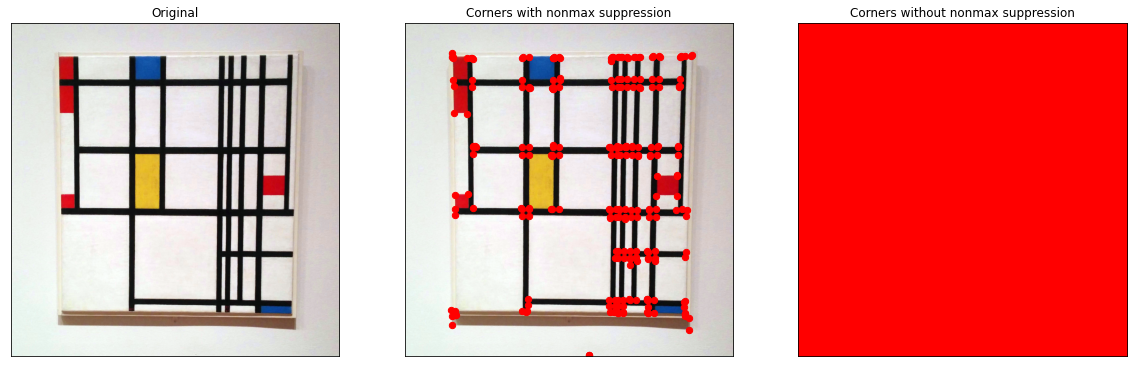

In [13]:
img = cv2.cvtColor(cv2.imread('piet.png'), cv2.COLOR_BGR2RGB)
x, y = HarrisCorner(img, sigmaX=3, sigmaY=3, k=0.05)
x_, y_ = HarrisCorner(img, sigmaX=3, sigmaY=3, k=0.05, non_max_suppr=False)
# plot
plt.subplot(1, 3, 1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(img)
plt.scatter(x, y, c='r', s=40)
plt.title('Corners with nonmax suppression'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(img)
plt.scatter(x_, y_, c='r', s=40)
plt.title('Corners without nonmax suppression'), plt.xticks([]), plt.yticks([])
plt.show()

## Qualitative comparison with OpenCV implementation
Note the difference between the plotting of our implementation and OpenCV implementation

In [16]:
img = cv2.cvtColor(cv2.imread('books.jpg'), cv2.COLOR_BGR2RGB)
img_cv = img.copy()
x, y = HarrisCorner(img, ksize=5, sigmaX=3, sigmaY=3, k=0.05)
dst = cv2.cornerHarris(np.float32(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)), 3, 3, 0.1)
# Results are marked through the dilated corners 
dst = cv2.dilate(dst, None, iterations = 3) 
# Reverting back to the original image, with optimal threshold value 
img_cv[dst > 0.01 * dst.max()] = [255, 0, 0]
# plot
plt.subplot(1, 3, 1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(img)
plt.scatter(x, y, c='r', s=40)
plt.title('Corners (our implementation)'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(img_cv)
plt.title('Corners (opencv implementation)'), plt.xticks([]), plt.yticks([])
plt.show()

NameError: name 'HarrisCorner' is not defined

C:\Users\Albert Chung\AppData\Local\Temp\ipykernel_31500\2521979198.py:8: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobelX = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]), dtype=np.float)
C:\Users\Albert Chung\AppData\Local\Temp\ipykernel_31500\2521979198.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sobelY = np.array(([-1, -2,

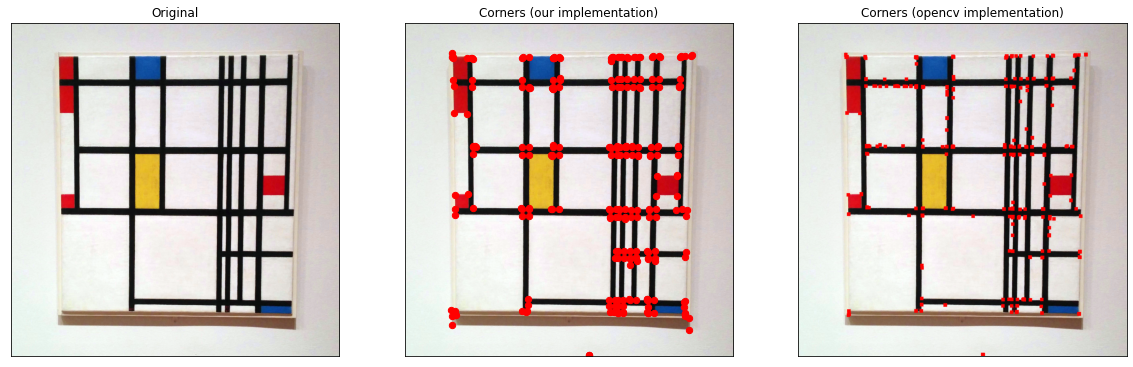

In [15]:
img = cv2.cvtColor(cv2.imread('piet.png'), cv2.COLOR_BGR2RGB)
img_cv = img.copy()
x, y = HarrisCorner(img, ksize=5, sigmaX=3, sigmaY=3, k=0.05)
dst = cv2.cornerHarris(np.float32(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)), 2, 3, 0.1)
# Results are marked through the dilated corners 
dst = cv2.dilate(dst, None, iterations = 10) 
# Reverting back to the original image, with optimal threshold value 
img_cv[dst > 0.01 * dst.max()] = [255, 0, 0]
# plot
plt.subplot(1, 3, 1), plt.imshow(img)
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 2), plt.imshow(img)
plt.scatter(x, y, c='r', s=40)
plt.title('Corners (our implementation)'), plt.xticks([]), plt.yticks([])
plt.subplot(1, 3, 3), plt.imshow(img_cv)
plt.title('Corners (opencv implementation)'), plt.xticks([]), plt.yticks([])
plt.show()